In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.ndimage

def cv_show(title, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(660, 1066, 3)


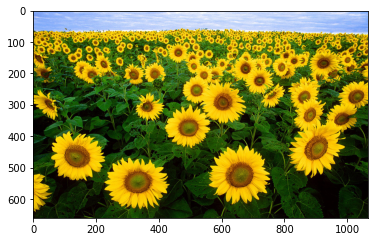

In [2]:
img = cv2.imread('sunflowers.jpeg')
plt.imshow(img[:,:,::-1])
print(img.shape)

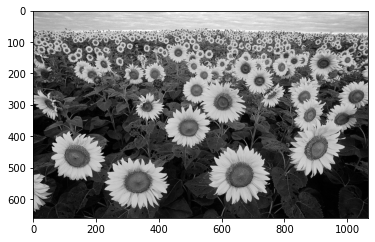

In [3]:
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY).astype('float64')
plt.imshow(gray, cmap='gray')

In [83]:
def GaussianKernal1D(sigma):
    half_length = np.ceil(3*sigma)
    #half_length = np.ceil(sigma)
    x = np.arange(-half_length, half_length + 1).reshape(-1,1)
    g = 1/np.sqrt(2 * math.pi * (sigma**2)) * np.exp(-x**2 / (2*(sigma**2)))
    gd = -x/(sigma**2) * g
    return g, gd

# Ex 8.1

In [84]:
def scaleSpaced(img, sigma, n):
    img_scales = []
    for i in range(n):
        sigma = sigma*((2**(1/(n-1)))**i)
        #sigma = sigma*(2**i)
        g, gd = GaussianKernal1D(sigma)
        img_scale = cv2.filter2D(cv2.filter2D(img.copy(), -1, g), -1, g.T)
        img_scales.append(img_scale)
    img_scales = np.array(img_scales)
    
    return img_scales

In [85]:
sigma = 1.6
n = 5
img_scales = scaleSpaced(gray, sigma, n)

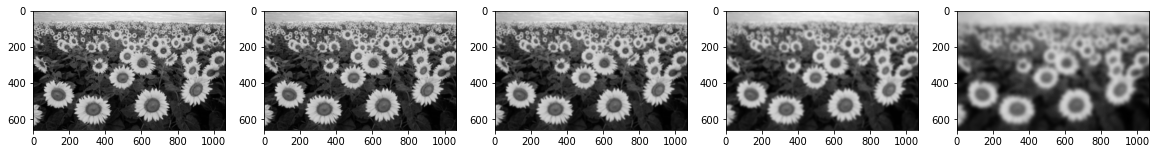

In [86]:
plt.figure(figsize=(20,20))
for i in range(n):
    plt.subplot(1, n, i+1)
    
    plt.imshow(img_scales[i, :, :], cmap='gray')

# Ex 8.2

In [87]:
def differenceOfGaussian(img, sigma, n):
    img_scales = scaleSpaced(img, sigma, n)
    DoGs = []
    for i in range(img_scales.shape[0]-1):
        DoG = img_scales[i+1, :, :] - img_scales[i, :, :]
        DoGs.append(DoG)
    DoGs = np.array(DoGs)
    return DoGs
        

In [88]:
sigma = 1.6
n = 5
DoGs = differenceOfGaussian(gray, sigma, n)

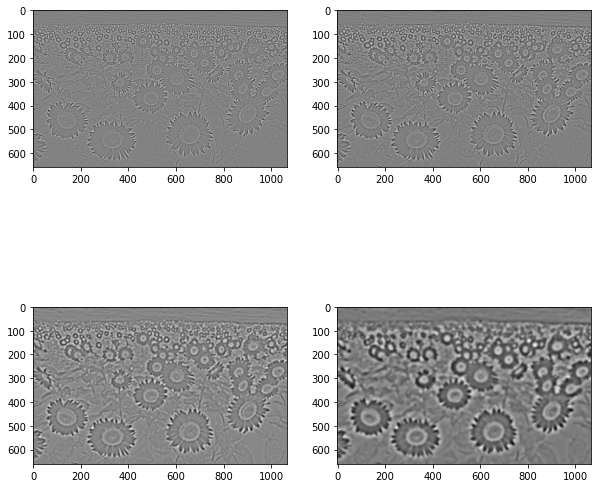

In [89]:
plt.figure(figsize=(10,10))
for i in range(n-1):
    plt.subplot(2, 2, i+1)
    
    plt.imshow(DoGs[i, :, :], cmap='gray')

# Ex 8.3

In [90]:
def detectBlobs(img, sigma, n, threshold):
    DoGs = differenceOfGaussian(img, sigma, n)
    scales, rows, columns = DoGs.shape
    
    crit_positiveNumb = np.ones((rows-2, columns-2))
    crit_negativeNumb = np.ones((rows-2, columns-2))
    
    
    
    Blobs = {}
    ## non-maximum suppression
    for scale in range(1, scales-1):
        criteria_thresh = np.logical_or(DoGs[scale, 1:rows-1, 1:columns-1]>threshold, DoGs[scale, 1:rows-1, 1:columns-1]<(-threshold) )
        for k in range(-1,2):
            for i in range(-1, 2):
                for j in range(-1, 2):
                    crit_positive = crit_positiveNumb * ( DoGs[scale, 1:rows-1, 1:columns-1]>=DoGs[scale+k, 1+i:(rows-1)+i, 1+j:(columns-1)+j] )
                    crit_negative = crit_negativeNumb * ( DoGs[scale, 1:rows-1, 1:columns-1]<=DoGs[scale+k, 1+i:(rows-1)+i, 1+j:(columns-1)+j] )
        Blobs[scale] = np.where( (criteria_thresh * (crit_positive + crit_negative)) == 1 )
    
    return Blobs

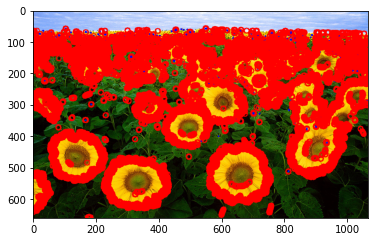

In [93]:
image = img.copy()
sigma = 1.6
n = 5
threshold = 15 
Blobs = detectBlobs(gray, sigma, n, threshold)
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
for key in Blobs.keys():
    Blob = Blobs[key]
    for i, j in zip(Blob[0], Blob[1]):
        cv2.circle(image, (int(j), int(i)), int(key**3), colors[key], 2)
plt.imshow(image[:,:,::-1])

# Ex 8.4

In [46]:
def transformImg(img, theta, scale):
    img_trans = scipy.ndimage.zoom(scipy.ndimage.rotate(img.copy(), angle=theta, reshape=False), (scale, scale, 1))
    return img_trans

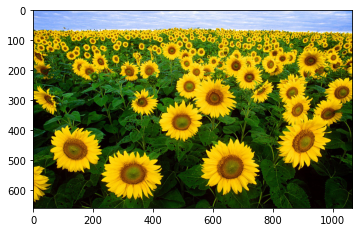

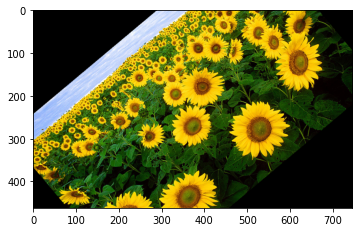

In [47]:
image = img.copy()
theta = 40
scale = 0.7
image_trans = transformImg(image, theta, scale)

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(image[:,:,::-1])

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.imshow(image_trans[:,:,::-1])


# Ex 8.5

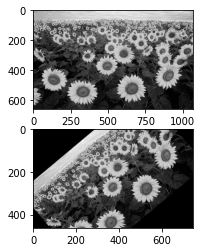

In [113]:
img1 = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(image_trans.copy(), cv2.COLOR_BGR2GRAY)
plt.subplot(2,1,1)
plt.imshow(img1, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(img2, cmap='gray')

In [114]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

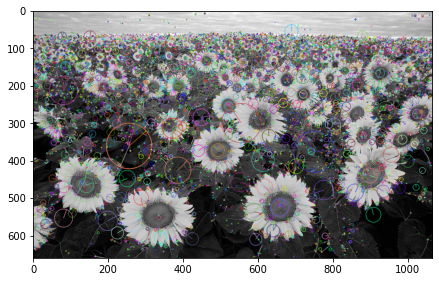

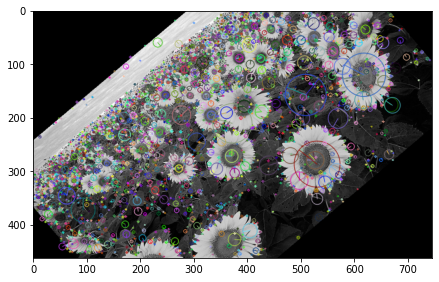

In [115]:
## Show features
kp1_img = cv2.drawKeypoints(img1.copy(), kp1, image.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(kp1_img)

kp2_img = cv2.drawKeypoints(img2.copy(), kp2, image_trans.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(kp2_img)

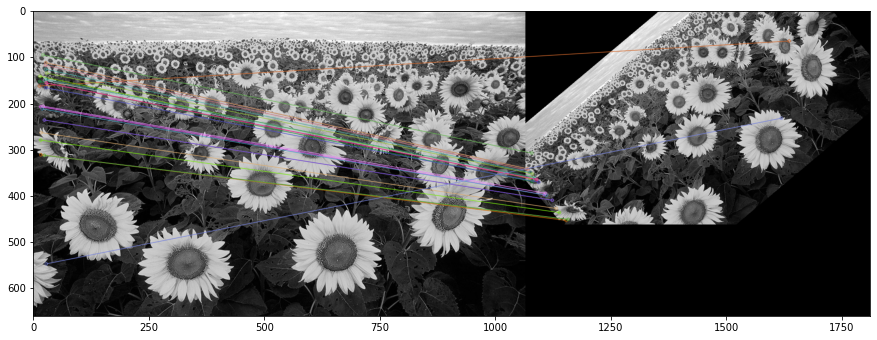

In [117]:
## Matcher with crossCheck
matcher = cv2.BFMatcher(crossCheck=True)
matches = matcher.match(des1, des2)
#matches = sorted(matches, key=lambda x:x.distance)
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:25], None, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(match_img, cmap='gray')

cv_show('match', match_img)

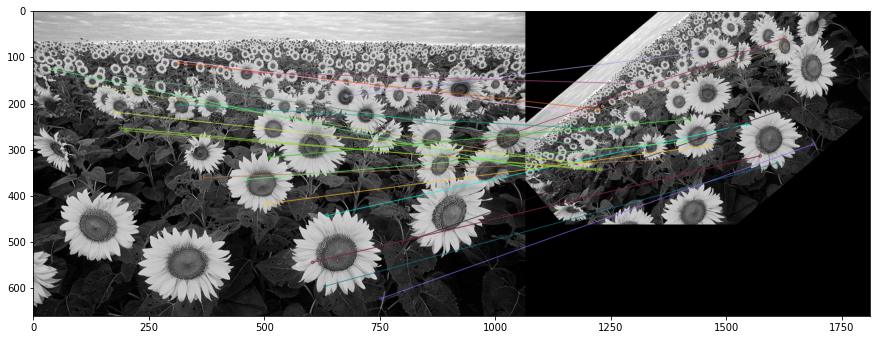

In [119]:
## Matcher with Ratio_test
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(des1, des2, k=2)
good = []
for i, j in matches:
    if i.distance / j.distance < 0.7:
        good.append(i)
good = sorted(good, key=lambda x:x.distance)
match_img = cv2.drawMatches(img1, kp1, img2, kp2, good[:25], None, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(match_img, cmap='gray')

cv_show('match', match_img)

# Ex 8.6

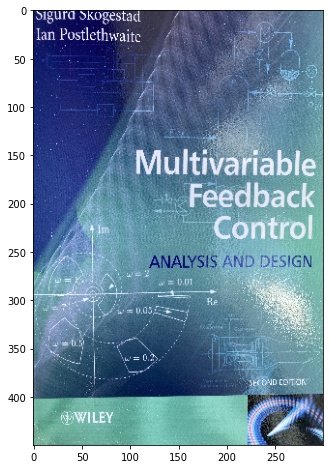

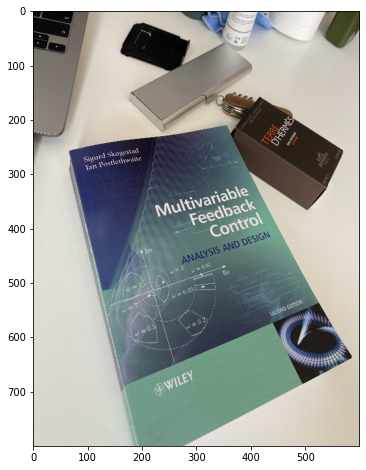

In [120]:
image1 = cv2.imread('IMG_1.png')
image1 = cv2.resize(image1, (300, 450))
image2 = cv2.imread('IMG_2.png')
image2 = cv2.resize(image2, (600, 800))
plt.figure(figsize=(8,8))
plt.imshow(image1[:,:,::-1])

plt.figure(figsize=(8,8))
plt.imshow(image2[:,:,::-1])


image1_gray = cv2.cvtColor(image1.copy(), cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2.copy(), cv2.COLOR_BGR2GRAY)

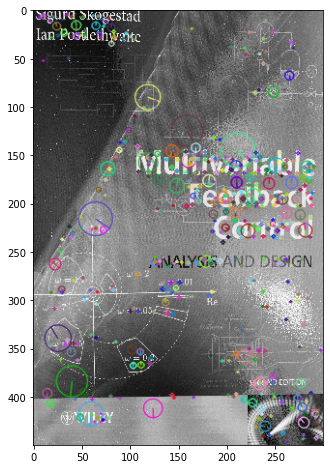

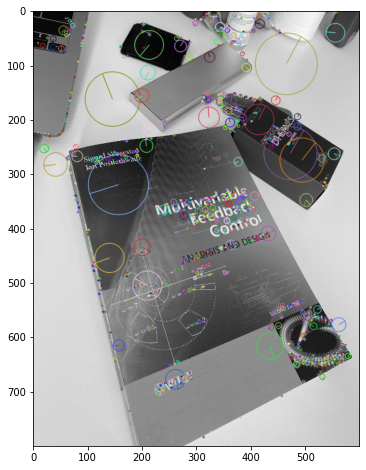

In [121]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray, None)
kp2, des2 = sift.detectAndCompute(image2_gray, None)

kp1_image = cv2.drawKeypoints(image1_gray.copy(), kp1, image1.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_image = cv2.drawKeypoints(image2_gray.copy(), kp2, image2.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8,8))
plt.imshow(kp1_image)

plt.figure(figsize=(8,8))
plt.imshow(kp2_image)

In [122]:
def BF_matcher_CrossCheck(des1, des2):
    matcher = cv2.BFMatcher()
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x:x.distance)
    return matches

In [123]:
matches = BF_matcher_CrossCheck(des1, des2)
match_img = cv2.drawMatches(image1.copy(), kp1, image2.copy(), kp2, matches[:50], None, flags=2)
cv_show('match', match_img)

In [124]:
def BF_matcher_RatioTest(des1, des2, Ratio):
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)
    good = []
    for i, j in matches:
        if i.distance / j.distance < Ratio:
            good.append(i)
    good = sorted(good, key=lambda x:x.distance)
    return good

In [125]:
matches = BF_matcher_RatioTest(des1, des2, 0.7)
match_img = cv2.drawMatches(image1.copy(), kp1, image2.copy(), kp2, matches[:50], None, flags=2)
cv_show('match', match_img)